In [65]:
import os
import sys

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(".."))

from eda.models import ConversationLine
from eda.parsing import Conversations, Participants
from eda.sentiments import SentimentType

participants = Participants()
conversations = Conversations(participants)

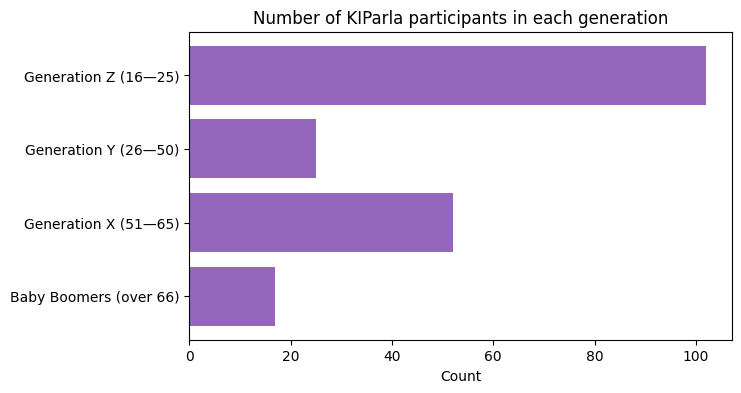

In [66]:
generation_counts_series = participants.df["generation"].value_counts()

result = sorted(
    zip(
        generation_counts_series.index.tolist(),
        generation_counts_series.values.tolist(),
    ),
    key=lambda pair: pair[0],
    reverse=True,
)

generations, counts = zip(*result)
generations = list(map(str, generations))
plt.figure(figsize=(7, 4))
plt.xlabel("Count")
plt.title("Number of KIParla participants in each generation")
plt.barh(generations, counts, facecolor="C4")
plt.show()

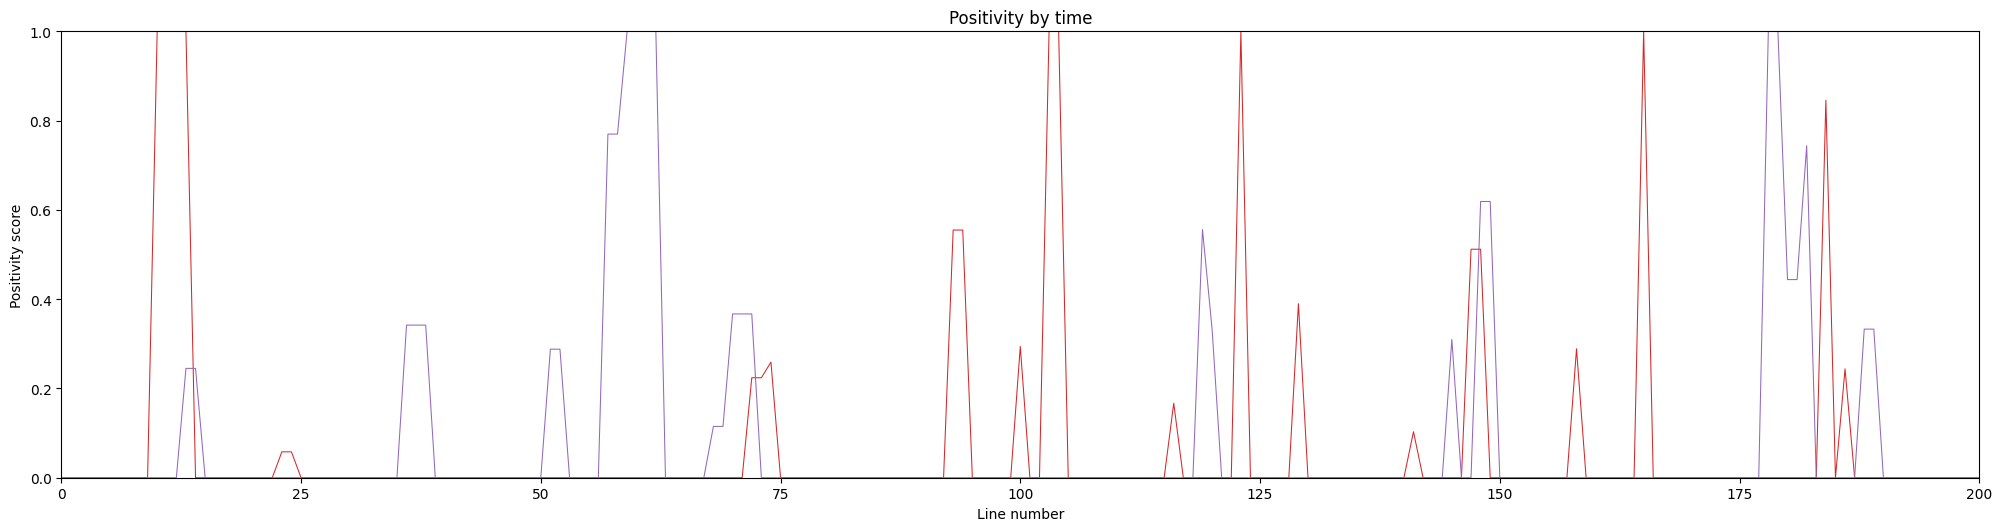

In [67]:
from collections.abc import Sequence

INTERPOLATE_SENTIMENTS = True
N_LINES = 200

plt.figure(figsize=(20, 5))
plt.margins(x=0, y=0)
plt.tight_layout()

plt.title("Positivity by time")
plt.xlabel("Line number")
plt.ylabel("Positivity score")


def interpolate_sentiments(
    line_ids: Sequence[int], sentiments: Sequence[float], last_tu_id: int
) -> tuple[list[int], list[float]]:
    revised_sentiments = []
    i = 0
    sentiment = sentiments[i]
    for tu_id in range(last_tu_id + 1):
        if i + 1 < len(line_ids) and tu_id == line_ids[i + 1]:
            i += 1
            sentiment = sentiments[i]
        revised_sentiments.append(sentiment)
    return list(range(last_tu_id + 1)), revised_sentiments


conversation = conversations.conversation("KPC001")
conversation.load_sentiment_scores()
lines_by_participant = conversation.lines_by_participant(up_to_line=N_LINES)

for i, (participant, lines) in enumerate(lines_by_participant.items(), start=3):
    line_ids, sentiments = zip(
        *((line.tu_id, line.sentiments.positive) for line in lines)
    )
    if INTERPOLATE_SENTIMENTS:
        line_ids, sentiments = interpolate_sentiments(line_ids, sentiments, N_LINES)
    plt.plot(line_ids, sentiments, color=f"C{i}", linewidth=0.75)

plt.show()

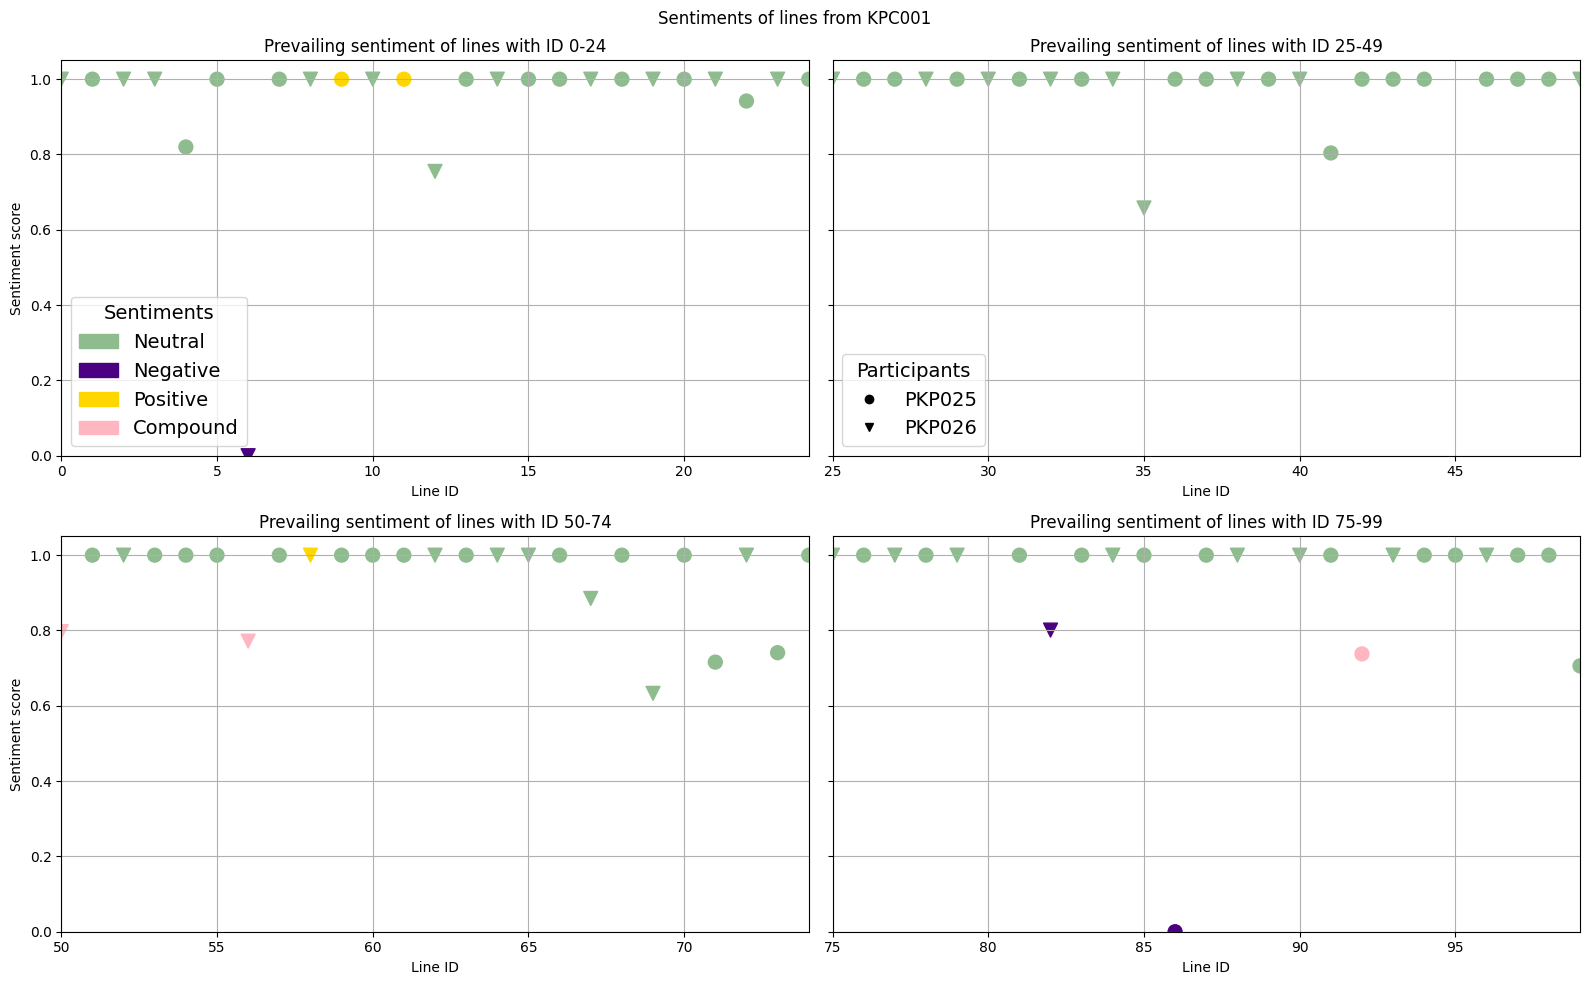

In [68]:
import math

from matplotlib.axes import Axes
from matplotlib.lines import Line2D

N_LINES = 100
LINES_PER_SUBPLOT = 25
N_COLUMNS = 2

n_subplots = math.ceil(N_LINES / LINES_PER_SUBPLOT)
n_rows = math.ceil(n_subplots / N_COLUMNS)

conversation = conversations.conversation("KPC001")
prevailing_sentiments = [
    line.sentiments.prevailing_sentiment() for line in conversation[:N_LINES]
]

colours, values = zip(
    *(
        (sentiment.type.default_colour, sentiment.score)
        for sentiment in prevailing_sentiments
    )
)
markers = ["o", "v"]

fig, axes = plt.subplots(
    nrows=n_rows, ncols=N_COLUMNS, figsize=(16, 5 * n_rows), sharey=True
)

axes = [axes] if isinstance(axes, Axes) else axes.flat
for i in range(n_subplots):
    start = i * LINES_PER_SUBPLOT
    end = min((i + 1) * LINES_PER_SUBPLOT, N_LINES)
    ax = axes[i]

    for j, participant in enumerate(conversation.participants):
        indices = [
            index
            for index in range(start, end)
            if conversation.lines.iloc[index].participant == participant
        ]
        if not indices:
            continue

        y = [values[index] for index in indices]
        c = [colours[index] for index in indices]
        ax.scatter(indices, y, c=c, marker=markers[j], s=100)

    ax.set_xlim(start, end - 1)
    ax.set_ylim(0, 1.05)
    ax.set_title(f"Prevailing sentiment of lines with ID {start}-{end - 1}")
    ax.set_xlabel("Line ID")
    if i % n_rows == 0:
        ax.set_ylabel("Sentiment score")
    ax.grid(True)

colours_by_label = {
    sentiment.type.default_colour: sentiment.type.name.capitalize()
    for sentiment in prevailing_sentiments
}
handles = [
    mpatches.Patch(color=colour, label=label)
    for colour, label in colours_by_label.items()
]

marker_handles = [
    Line2D([0], [0], marker=marker, color="black", linestyle="", label=participant.code)
    for participant, marker in zip(conversation.participants, markers)
]

axes[0].legend(
    handles=handles,
    title="Sentiments",
    fontsize=14,
    title_fontsize=14,
    loc="lower left",
)
axes[1].legend(
    title="Participants",
    handles=marker_handles,
    fontsize=14,
    title_fontsize=14,
    loc="lower left",
)

plt.suptitle(f"Sentiments of lines from {conversation.code}")
plt.tight_layout()
plt.show()

KPN003 sentiment scores: 100%|██████████| 1574/1574 [00:01<00:00, 1015.00lines/s]


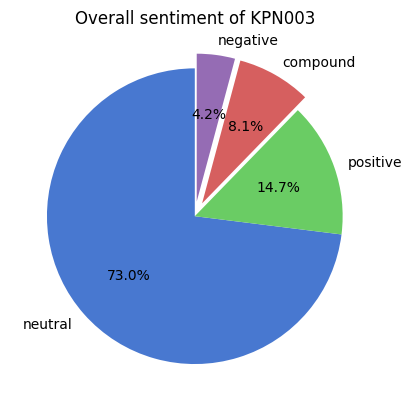

In [69]:
from collections import Counter
from collections.abc import Iterable
from typing import cast

from eda.utils import round_precise

# Change this for different results
EXCLUDE_TRUE_NEUTRALS = False

conversation = conversations.conversation("KPN003")
conversation.load_sentiment_scores(progress_bar=True)


def sentiments_from_lines(
    lines: Iterable[ConversationLine], exclude_true_neutrals: bool = False
) -> tuple[list[str], list[float]]:
    sentiments = Counter()

    for line in lines:
        if not line.sentiments.has_loaded_scores():
            continue
        if not line.sentiments.has_scores():
            continue
        if exclude_true_neutrals and line.sentiments.neutral == 1.0:
            continue
        sentiments += line.sentiments.score_counts

    total_sum = sum(sentiments.values())
    names, scores = zip(
        *(
            (
                SentimentType(sentiment_name).display_name,
                round_precise(score / total_sum * 100, 2),
            )
            for sentiment_name, score in sentiments.items()
        )
    )
    return list(names), list(scores)


n_lines = len(conversation)
names, scores = sentiments_from_lines(
    cast(Iterable[ConversationLine], conversation.lines),
    exclude_true_neutrals=EXCLUDE_TRUE_NEUTRALS,
)
explode = [0.1 * (percent < 10) for percent in scores]

fig, ax = plt.subplots()
ax.pie(
    scores,
    labels=names,
    autopct="%1.1f%%",
    explode=explode,
    colors=sns.color_palette("muted6"),
    startangle=90,
)
ax.set_title(f"Overall sentiment of {conversation.code}")

plt.show()

In [70]:
conversations.read_all(parallel=True, load_sentiments=True)

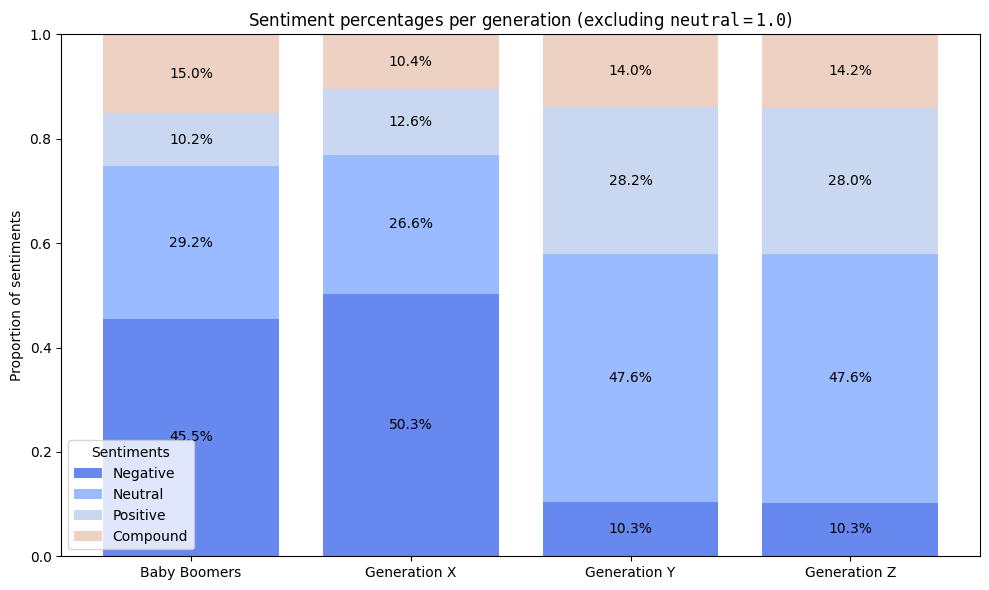

In [71]:
import numpy as np
import seaborn as sns

from eda.models import Generation

EXCLUDE_TRUE_NEUTRALS = True

lines_by_generation = Generation.create_mapping()
for conversation in conversations:
    for line in conversation.lines:
        generation = line.participant.generation
        lines_by_generation[generation].append(line)

sentiment_names = None
generation_names = []
data = []

for generation, lines in lines_by_generation.items():
    generation_names.append(generation.name)
    sentiment_names, scores = sentiments_from_lines(
        lines, exclude_true_neutrals=EXCLUDE_TRUE_NEUTRALS
    )

    total = sum(scores)
    proportions = [score / total for score in scores]
    data.append(proportions)

assert sentiment_names is not None
data = np.array(data).T

colours = sns.color_palette("coolwarm")
x = np.arange(len(generation_names))

fig, ax = plt.subplots(figsize=(10, 6))
bottom = np.zeros(len(generation_names))
for sentiment, colour, row in zip(sentiment_names, colours, data):
    bars = ax.bar(x, row, bottom=bottom, label=sentiment.capitalize(), color=colour)
    for bar, value in zip(bars, row):
        percentage = round_precise(value * 100, 1)
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_y() + bar.get_height() / 2,
            f"{percentage}%",
            ha="center",
            va="center",
            color="black",
            fontsize=10,
        )
    bottom += row

plot_title = "Sentiment percentages per generation"
if EXCLUDE_TRUE_NEUTRALS:
    plot_title += r" (excluding $\mathtt{neutral = 1.0}$)"

ax.set_xticks(x)
ax.set_xticklabels(generation_names)
ax.set_ylabel("Proportion of sentiments")
ax.set_ylim(0, 1)
ax.set_title(plot_title)
ax.legend(title="Sentiments")

plt.tight_layout()
plt.show()

In [ ]:
conversations.read_all(parallel=True, load_prosodic=True)

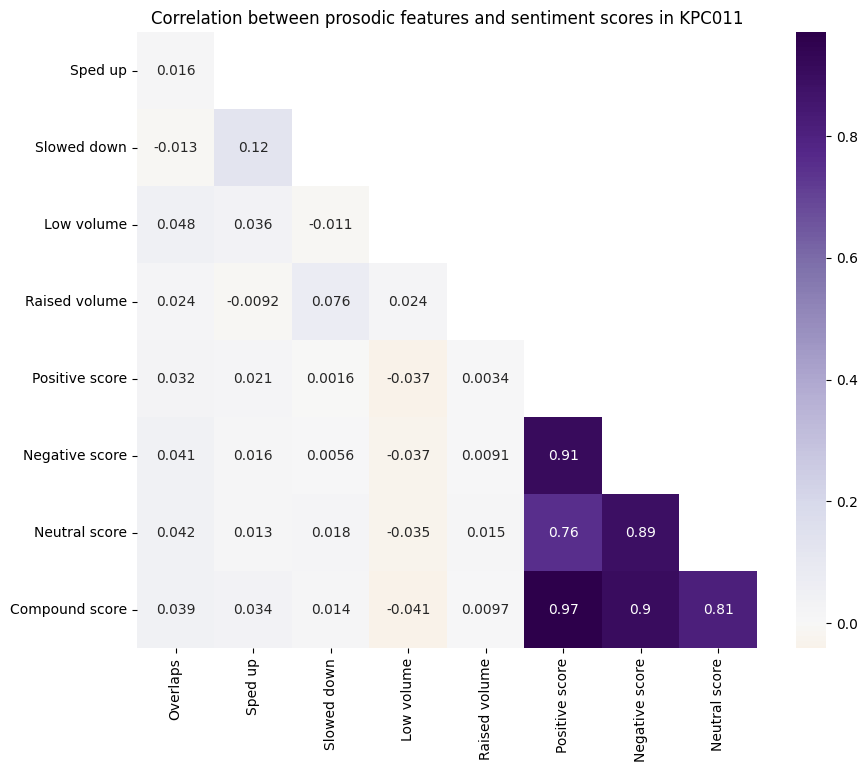

In [98]:
import numpy as np
import pandas as pd


def human_name_from_snake_case(name: str) -> str:
    return " ".join(name.split("_")).capitalize()


conversation = conversations.conversation("KPC011")
data = []

for line in conversation:
    n_overlapping = len(line.overlapping_phrases)
    n_sped_up = len(line.sped_up_phrases)
    n_slowed_down = len(line.slowed_down_phrases)
    n_low_volume = len(line.low_volume_phrases)
    n_raised_volume = len(line.raised_volume_phrases)
    positive_score = line.sentiments.positive
    negative_score = line.sentiments.negative
    neutral_score = line.sentiments.neutral
    compound_score = line.sentiments.compound
    data.append({
        "overlaps": n_overlapping,
        "sped_up": n_sped_up,
        "slowed_down": n_slowed_down,
        "low_volume": n_low_volume,
        "raised_volume": n_raised_volume,
        "positive_score": positive_score,
        "negative_score": negative_score,
        "neutral_score": neutral_score,
        "compound_score": compound_score,
    })

prosodic_emotions = pd.DataFrame(data)
prosodic_emotions.columns = [
    human_name_from_snake_case(column_name)
    for column_name in prosodic_emotions.columns.values
]

correlation_matrix = prosodic_emotions.corr(numeric_only=True)

# Upper triangular version of the array, e.g.
# True True -> True True
# True True    False True
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

correlation_matrix = correlation_matrix.mask(mask)
correlation_matrix = correlation_matrix.dropna(how="all", axis=0)  # rows
correlation_matrix = correlation_matrix.dropna(how="all", axis=1)  # colums

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="PuOr", center=0)
plt.title(
    f"Correlation between prosodic features and sentiment scores in {conversation.code}"
)
plt.show()

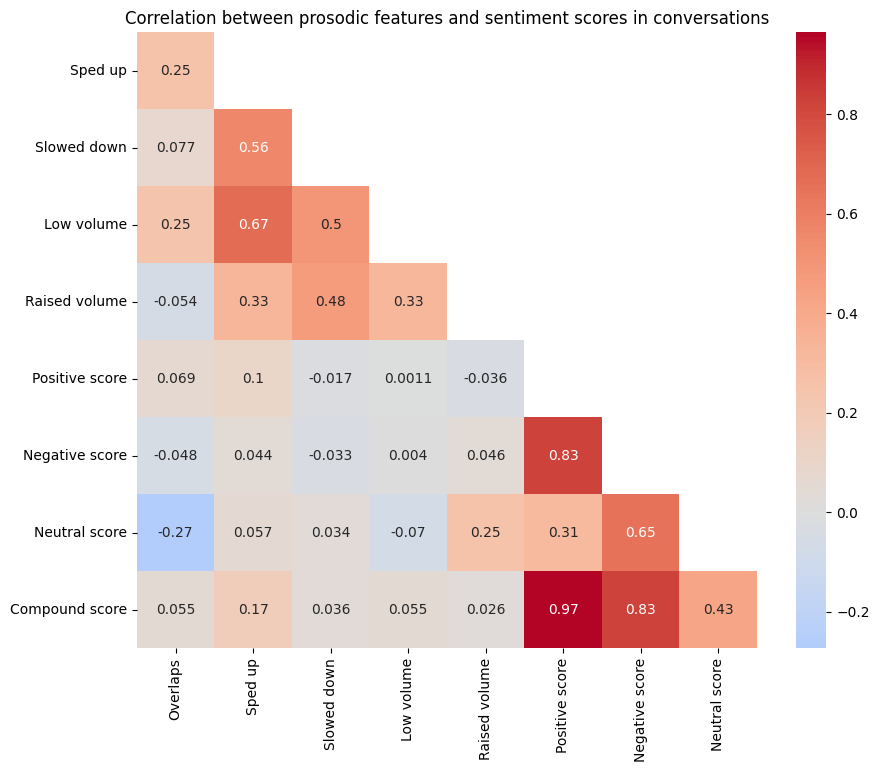

In [99]:
from typing import cast

NORMALISE_LINE_COUNTS = True

data = []

for conversation in conversations:
    conversation_data: dict[str, float] = cast(dict[str, float], Counter())
    n_lines = 0

    for line in conversation:
        conversation_data["overlaps"] += float(len(line.overlapping_phrases))
        conversation_data["sped_up"] += float(len(line.sped_up_phrases))
        conversation_data["slowed_down"] += float(len(line.slowed_down_phrases))
        conversation_data["low_volume"] += float(len(line.low_volume_phrases))
        conversation_data["raised_volume"] += float(len(line.raised_volume_phrases))
        conversation_data["positive_score"] += line.sentiments.positive
        conversation_data["negative_score"] += line.sentiments.negative
        conversation_data["neutral_score"] += line.sentiments.neutral
        conversation_data["compound_score"] += line.sentiments.compound
        n_lines += 1

    normalised = {
        key: value / n_lines if NORMALISE_LINE_COUNTS else value
        for key, value in conversation_data.items()
    }
    data.append(normalised)

prosodic_emotions = pd.DataFrame(data)
prosodic_emotions.columns = [
    human_name_from_snake_case(column_name) for column_name in prosodic_emotions.columns
]
correlation_matrix = prosodic_emotions.corr(numeric_only=True)

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
correlation_matrix = correlation_matrix.mask(mask)
correlation_matrix = correlation_matrix.dropna(how="all", axis=0)  # rows
correlation_matrix = correlation_matrix.dropna(how="all", axis=1)  # colums

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title(
    "Correlation between prosodic features and sentiment scores in conversations"
)
plt.show()

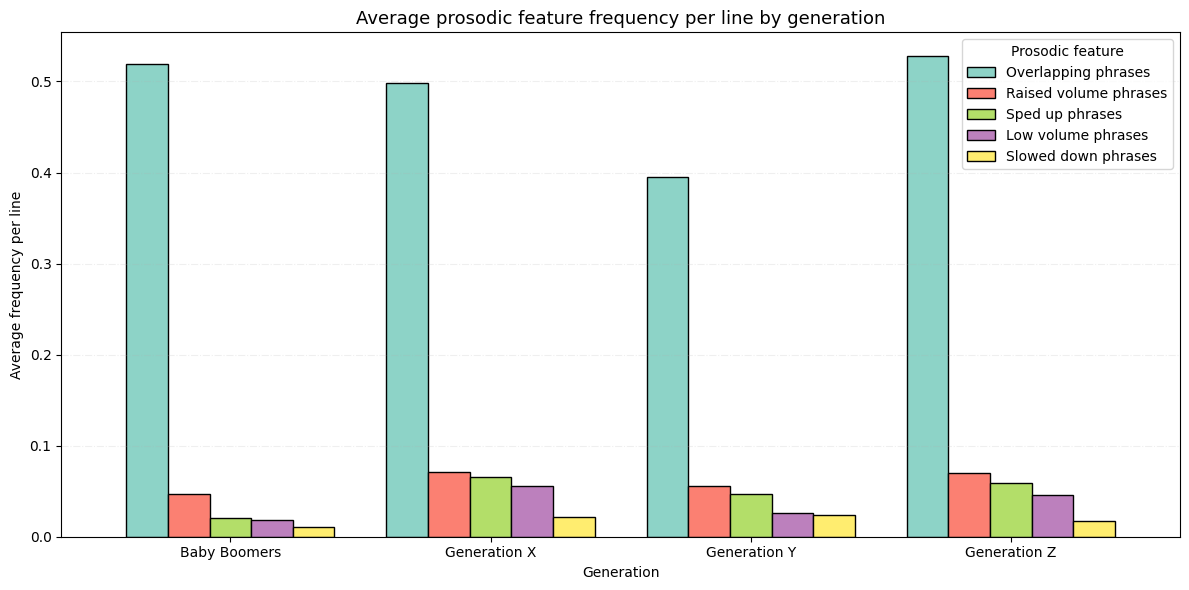

In [100]:
from collections import Counter, defaultdict
from collections.abc import Generator

from eda.models import Generation, Participant

data = Generation.create_mapping()


def filter_prosodic_attributes(
    line: ConversationLine,
) -> Generator[tuple[str, str]]:
    yield from (
        (name, value) for name, value in vars(line).items() if name.endswith("phrases")
    )


def prosodic_frequencies(participant: Participant) -> dict[str, float]:
    participant_lines = conversations.participant_lines(participant)
    participant_data = defaultdict(int)
    n_lines = 0
    for line in participant_lines:
        for name, value in filter_prosodic_attributes(line):
            participant_data[name] += len(value)
        n_lines += 1

    norm_participant_data = {
        key: value / n_lines for key, value in participant_data.items()
    }
    return norm_participant_data


def prosodic_counts_by_generation() -> dict[str, dict[str, float]]:
    for participant in participants:
        generation = participant.generation
        data[generation].append(prosodic_frequencies(participant))

    result = {}
    for generation, participants_frequencies in data.items():
        total_generation_counts = Counter()
        for participant_frequencies in participants_frequencies:
            counts = Counter(participant_frequencies)
            total_generation_counts += counts

        result[generation.name] = {
            human_name_from_snake_case(prosodic_feature): count
            / len(participants_frequencies)
            for prosodic_feature, count in total_generation_counts.items()
        }
    return result


counts = prosodic_counts_by_generation()
prosodic_df = pd.DataFrame.from_dict(counts, orient="index")

prosodic_df.loc["Sum"] = prosodic_df.sum()
prosodic_df = prosodic_df.T.sort_values(by="Sum", ascending=False).T
prosodic_df = prosodic_df.drop("Sum")
prosodic_df.plot(
    kind="bar", figsize=(12, 6), width=0.8, colormap="Set3", edgecolor="black"
)

plt.grid(axis="y", linestyle="-.", alpha=0.2)
plt.title("Average prosodic feature frequency per line by generation", fontsize=13)
plt.xlabel("Generation")
plt.ylabel("Average frequency per line")
plt.xticks(rotation=0)
plt.legend(title="Prosodic feature", loc="upper right")
plt.tight_layout()

plt.show()